# Create a Neural Network from scratch

The Operation Class will have:

- Input Nodes
- Output Nodes
- A global Default Graph Variable
- Compute method, overwritten by children classes.

In [1]:
class Operation():
    
    def __init__(self, input_nodes=[]):
        
        self.input_nodes = input_nodes
        self.output_nodes = []
        
        for node in input_nodes:
            node.output_nodes.append(self)
        
        _default_graph.operations.append(self)
    
    # overwritten with any other operation
    def compute(self):
        pass

In [2]:
class add(Operation):
    
    def __init__(self, x, y):
        
        super().__init__([x, y])
    
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var + y_var

In [3]:
class multiply(Operation):
    
    def __init__(self, x, y):
        
        super().__init__([x, y])
    
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var * y_var

In [4]:
class matmul(Operation):
    
    def __init__(self, x, y):
        
        super().__init__([x, y])
    
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var.dot(y_var) # assuming numpy array

In [5]:
class Placeholder():
    
    def __init__(self):
        
        self.output_nodes = []
        
        _default_graph.placeholders.append(self)

In [6]:
class Variable():
    
    def __init__(self, initial_value=None):
        
        self.value = initial_value
        self.output_nodes = []
        
        _default_graph.variables.append(self)

In [7]:
class Graph():
    
    def __init__(self):
        
        self.operations = []
        self.placeholders = []
        self.variables = []
    
    def set_as_default(self):
        
        global _default_graph
        _default_graph = self

### An example

z = Ax + b

A = 10
b = 1

z = 10x + 1

In [8]:
g = Graph()
g.set_as_default()

In [9]:
A = Variable(10)

In [10]:
b = Variable(1)

In [11]:
x = Placeholder()

In [12]:
y = multiply(A, x)

In [13]:
z = add(y, b)

Now that the Graph has all the nodes, we need to execute all the operations within a Session. We'll use PostOrder Tree Transversal to make sure we execute the nodes in the correct order.

In [14]:
def traverse_postorder(operation):
    """
    Ax first, then Ax + b.
    """
    
    nodes_postorder = []
    
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)
    
    recurse(operation)
    return nodes_postorder

In [15]:
import numpy as np
class Session():
    
    def run(self, operation, feed_dict={}):
        # feed_dict will feed the placeholders
        
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:
            
            if type(node) == Placeholder:
                node.output = feed_dict[node]
            
            elif type(node) == Variable:
                node.output = node.value
            
            else:
                # Then I have an operation
                node.inputs = [input_node.output for input_node in node.input_nodes]
                
                node.output = node.compute(*node.inputs) # args
            
            if type(node.output) == list:
                
                node.output = np.array(node.output)
        
        return operation.output

In [16]:
sess = Session()

In [17]:
result = sess.run(operation=z, feed_dict={x:10})

In [18]:
result

101

### Now with Matrix Multiplication

In [19]:
g = Graph()

g.set_as_default()

In [20]:
A = Variable([[10, 20], [30, 40]])
b = Variable([1,2])
x = Placeholder()
y = matmul(A, x)
z = add(y, b)

In [21]:
sess = Session()

In [22]:
sess.run(operation=z, feed_dict={x: 10})

array([[101, 202],
       [301, 402]])

# Classification

## Activation Function

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def sigmoid(z):
    return 1 /(1 + np.exp(-z))

In [25]:
sample_z = np.linspace(-10, 10, 100)
sample_a = sigmoid(sample_z)

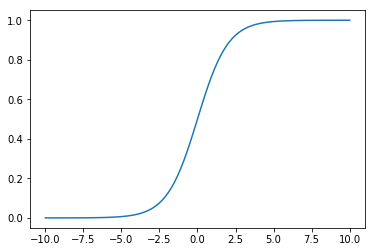

In [26]:
plt.plot(sample_z, sample_a);

In [27]:
class Sigmoid(Operation):
    
    def __init__(self, z):
        
        super().__init__([z])
    
    def compute(self, z_val):
        return 1 /(1 + np.exp(-z_val))

In [28]:
from sklearn.datasets import make_blobs

In [29]:
data = make_blobs(n_samples=50, n_features=2, centers=2, random_state=75)

In [30]:
features = data[0]
labels = data[1]

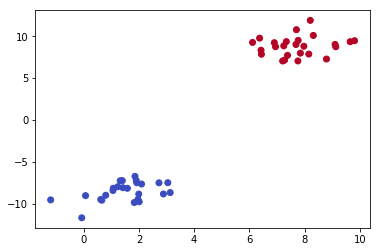

In [31]:
plt.scatter(features[:,0], features[:, 1], c=labels,cmap='coolwarm');

In [32]:
# Drawing a simple line to classify this dataset
x = np.linspace(-3, 11, 10)
y = -x + 5

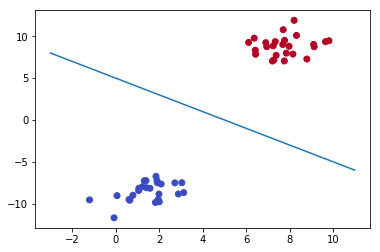

In [33]:
plt.scatter(features[:,0], features[:, 1], c=labels,cmap='coolwarm')
plt.plot(x, y);

## (1, 1) * f - 5 = 0

In [34]:
np.array([1,1]).dot([[8], [10]]) - 5

array([13])

Positive means that (8, 10) falls under the line - **red**

In [35]:
np.array([1,1]).dot([[2], [-10]]) - 5

array([-13])

Negative means that (2, -10) falls under the line - **blue**

In [36]:
g = Graph()
g.set_as_default()

In [37]:
x = Placeholder()

In [38]:
w = Variable([1,1])

In [39]:
b = Variable(-5)

In [40]:
z = add(matmul(w, x), b)

In [41]:
a = Sigmoid(z)

In [42]:
sess = Session()

In [43]:
sess.run(operation=a, feed_dict={x:[8, 10]})

0.999997739675702

It belongs to class 1

In [44]:
sess.run(operation=a, feed_dict={x:[2, -10]})

2.2603242979035746e-06

It belongs to class 0